In [2]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [6]:
# Define the Hotdog_NotHotdog dataset class
_optimizer = "Adam" #"SGD"  # , "SGD", "SGD Momentum"
_lr = 1e-4
_use_batchnorm = True
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='hotdog_nothotdog/'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path + '/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

# Define the SimpleCNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) if _use_batchnorm else None
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64) if _use_batchnorm else None
        
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64) if _use_batchnorm else None
        
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 64)
        self.bn_fc1 = nn.BatchNorm1d(64) if _use_batchnorm else None
        
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)
        if _use_batchnorm:
            x = self.bn1(x)
        x = self.pool(F.relu(x))
        
        x = self.conv2(x)
        if _use_batchnorm:
            x = self.bn2(x)
        x = self.pool(F.relu(x))
        
        x = self.conv3(x)
        if _use_batchnorm:
            x = self.bn3(x)
        x = self.pool(F.relu(x))
        
        x = x.view(-1, 64 * 16 * 16)
        x = self.fc1(x)
        if _use_batchnorm:
            x = self.bn_fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        return torch.sigmoid(x)

In [8]:
model = SimpleCNN()
model.load_state_dict(torch.load("model"))
model.eval()

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=64, bias=True)
  (bn_fc1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [15]:
# Set parameters
size = 128
batch_size = 64
train_transform = transforms.Compose([transforms.Resize((size, size)), transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), transforms.ToTensor()])

# Load the train dataset and split it into training and validation sets
trainset = Hotdog_NotHotdog(train=True, transform=train_transform,data_path="../hotdog_nothotdog")
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

# Create DataLoaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

testset = Hotdog_NotHotdog(train=False, transform=test_transform,data_path="../hotdog_nothotdog")
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [20]:
if torch.backends.mps.is_available():
    print("The code will run on MPS.")
    device = torch.device('mps')
elif torch.cuda.is_available():
    print("The code will run on GPU.")
    device = torch.device('cuda')
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
    device = torch.device('cpu')

The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator


Hotdog 0


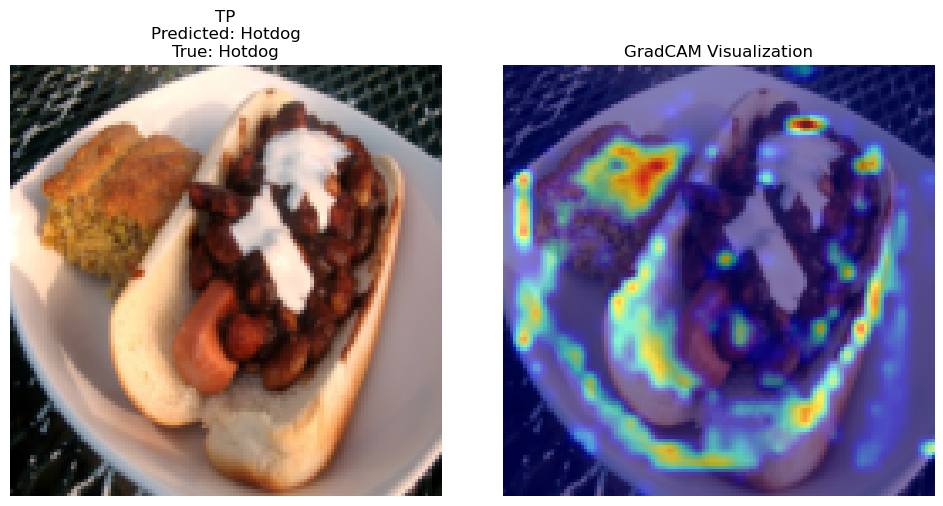

Category: TP
Predicted: Hotdog (Probability: 0.2135), True: Hotdog

Hotdog 0


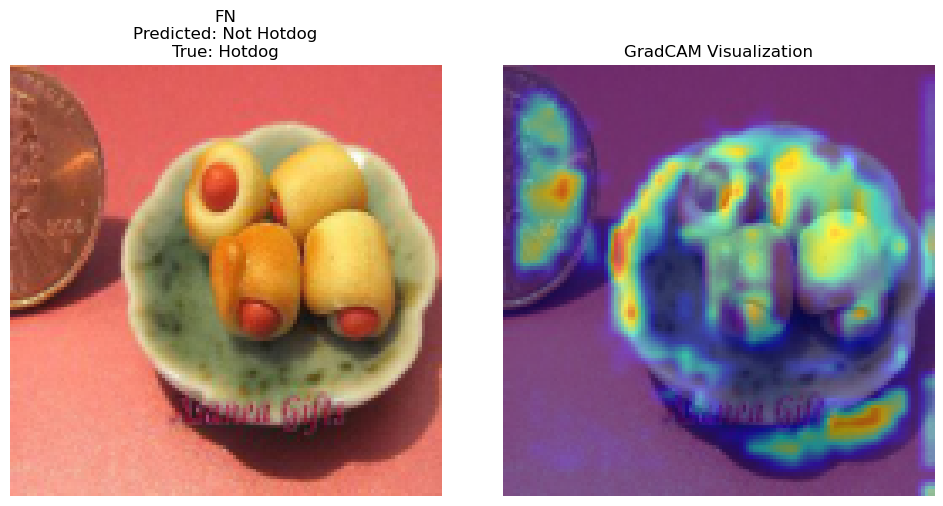

Category: FN
Predicted: Not Hotdog (Probability: 0.5876), True: Hotdog

Not Hotdog 1


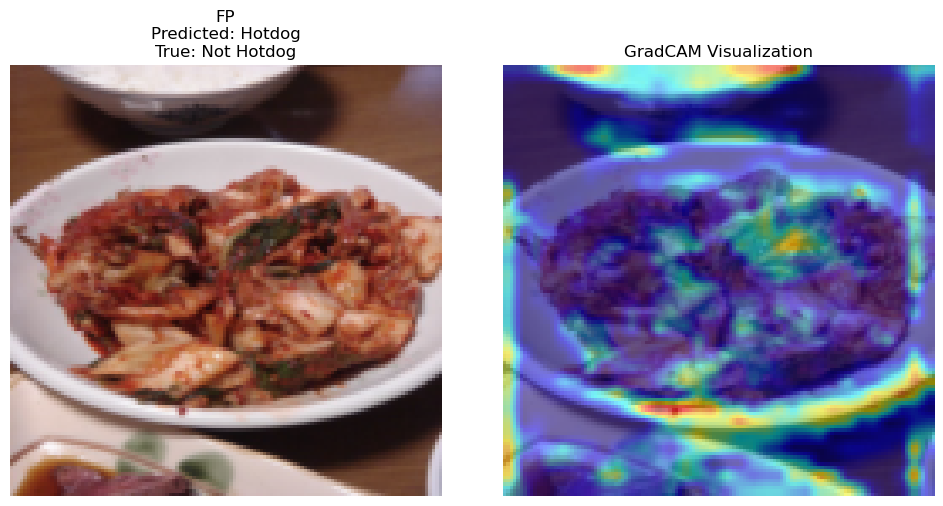

Category: FP
Predicted: Hotdog (Probability: 0.0980), True: Not Hotdog

Not Hotdog 1


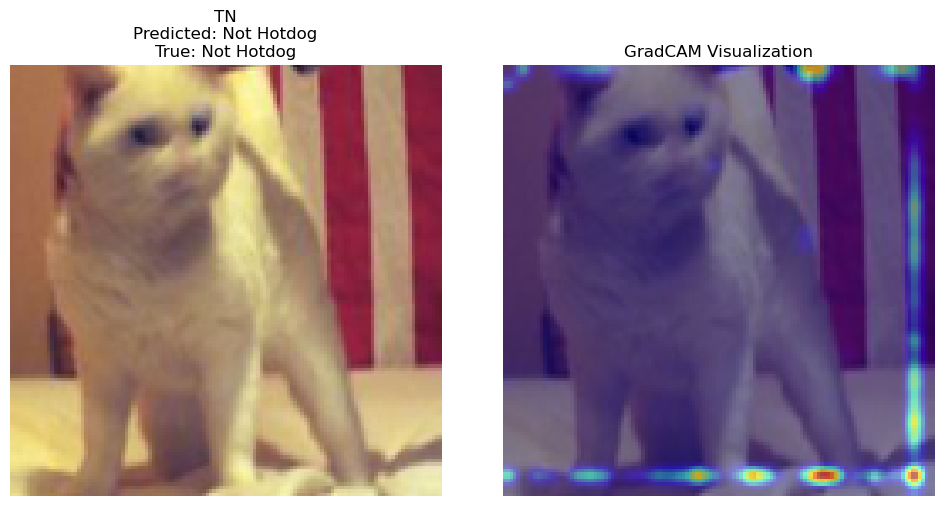

Category: TN
Predicted: Not Hotdog (Probability: 0.9266), True: Not Hotdog



In [68]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


def custom_target(output):
        if len(output.shape) == 1:
            return output[0] if target_label == 1 else 1 - output[0]
        else:
            return output[:, target_label]


def get_grad_cam_visualization(model, image_tensor, target_layer,target_label):
    # Preprocess the image
    input_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
    
    # Create a GradCAM object
    cam = GradCAM(model=model, target_layers=[target_layer])
    targets = [ClassifierOutputTarget(target_label)]
    # Generate the CAM

    def custom_target(output):
        if len(output.shape) == 1:
            return output[0] if target_label == 1 else 1 - output[0]
        else:
            return output[:, target_label]
            
    grayscale_cam = cam(input_tensor=input_tensor, targets=[custom_target])
    
    # Convert the PyTorch tensor to a numpy array and denormalize
    image_numpy = image_tensor.cpu().numpy().transpose(1, 2, 0)
    image_numpy = (image_numpy - image_numpy.min()) / (image_numpy.max() - image_numpy.min())
    
    # Overlay the CAM on the image
    visualization = show_cam_on_image(image_numpy, grayscale_cam[0], use_rgb=True)
    
    return visualization



examples = {
    'TP': None,  # True Positive: True Hotdog predicted as Hotdog
    'FN': None,  # False Negative: True Hotdog predicted as Not Hotdog
    'FP': None,  # False Positive: True Not Hotdog predicted as Hotdog
    'TN': None   # True Negative: True Not Hotdog predicted as Not Hotdog
}

model.eval()
target_layer = model.conv3

# Shuffle the test set to randomize the order
test_indices = list(range(len(testset)))
np.random.shuffle(test_indices)

for idx in test_indices:
    image, label = testset[idx]
    
    # Make prediction
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
    
    pred_prob = output.item()
    pred_class = "Not Hotdog" if pred_prob > 0.5 else "Hotdog"
    true_class = "Not Hotdog" if label == 1 else "Hotdog"
    
    # Determine the category of this prediction
    if true_class == "Hotdog" and pred_class == "Hotdog":
        category = 'TP'
    elif true_class == "Hotdog" and pred_class == "Not Hotdog":
        category = 'FN'
    elif true_class == "Not Hotdog" and pred_class == "Hotdog":
        category = 'FP'
    else:  # true_class == "Not Hotdog" and pred_class == "Not Hotdog"
        category = 'TN'
    
    # If we haven't found an example for this category yet, store it
    if examples[category] is None:
        examples[category] = (image, pred_class, true_class, pred_prob)
    
    # If we've found all four types of examples, break the loop
    if all(examples.values()):
        break

# Visualize the results
for category, (image, pred_class, true_class, pred_prob) in examples.items():
    if image is not None:
        if true_class == "Not Hotdog":
            label = 1
        else:
            label = 0
        print(true_class,label)
        vis = get_grad_cam_visualization(model, image, target_layer, label)
        
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f'{category}\nPredicted: {pred_class}\nTrue: {true_class}')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(vis)
        plt.title('GradCAM Visualization')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Category: {category}")
        print(f"Predicted: {pred_class} (Probability: {pred_prob:.4f}), True: {true_class}")
        print()
    else:
        print(f"No example found for category: {category}")
        print()